In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

/home/saeedzou/miniconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [3]:
# Set the random seed
torch.manual_seed(42)
# define lenet5
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [4]:
# define a function to train the model
def train(model, trainloader, testloader, criterion, optimizer, num_epochs, device):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0
        # train
        model.train()
        for images, labels in tqdm(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_acc += (preds == labels.data).float().mean()
        train_loss.append(running_loss / len(trainloader))
        train_acc.append(running_acc / len(trainloader))
        # test
        model.eval()
        running_loss = 0.0
        running_acc = 0.0
        with torch.no_grad():
            for images, labels in tqdm(testloader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs.data, 1)
                running_acc += (preds == labels.data).float().mean()
        test_loss.append(running_loss / len(testloader))
        test_acc.append(running_acc / len(testloader))
        print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'.format(epoch+1, train_loss[-1], train_acc[-1], test_loss[-1], test_acc[-1]))
    return train_loss, train_acc, test_loss, test_acc

In [5]:
# define a function for evaluating a single image that returns the logits and the predicted class
def evaluate(model, image, device):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        _, pred = torch.max(output.data, 1)
    return output, pred

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)
# save model weights
torch.save(model.state_dict(), 'initial_weights.pth')
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Ground truth label: 8
Logits: tensor([[-0.1018, -0.0106,  0.0736,  0.0219,  0.0084, -0.0585,  0.0037, -0.0537,
         -0.1509, -0.0553]], device='cuda:0')
Predicted class: tensor([2], device='cuda:0')


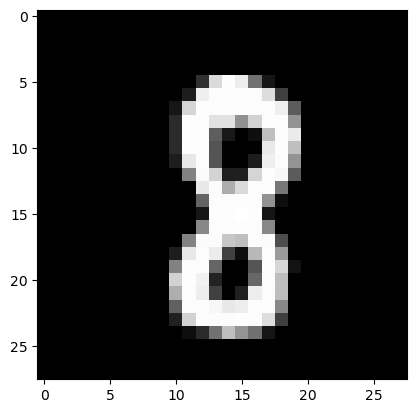

In [11]:
# select a random image from the training set, plot it and evaluate it and show its ground truth label
random_index = np.random.randint(0, len(trainset))
image, label = trainset[random_index]
plt.imshow(image.squeeze(), cmap='gray')
print('Ground truth label: {}'.format(label))
# print the logits and the predicted class
output, pred = evaluate(model, image.unsqueeze(0), device)
print('Logits: {}'.format(output))
print('Predicted class: {}'.format(pred))

In [12]:
train_loss, train_acc, test_loss, test_acc = train(model, trainloader, testloader, criterion, optimizer, 10, device)

100%|██████████| 313/313 [00:02<00:00, 106.68it/s]


Epoch: 1, Train Loss: 0.2024, Train Acc: 0.9363, Test Loss: 0.0665, Test Acc: 0.9788


100%|██████████| 313/313 [00:02<00:00, 109.61it/s]


Epoch: 2, Train Loss: 0.0630, Train Acc: 0.9806, Test Loss: 0.0458, Test Acc: 0.9851


100%|██████████| 313/313 [00:02<00:00, 114.85it/s]


Epoch: 3, Train Loss: 0.0475, Train Acc: 0.9852, Test Loss: 0.0438, Test Acc: 0.9854


100%|██████████| 313/313 [00:02<00:00, 117.99it/s]


Epoch: 4, Train Loss: 0.0366, Train Acc: 0.9886, Test Loss: 0.0376, Test Acc: 0.9878


100%|██████████| 313/313 [00:02<00:00, 114.84it/s]


Epoch: 5, Train Loss: 0.0313, Train Acc: 0.9905, Test Loss: 0.0333, Test Acc: 0.9890


100%|██████████| 313/313 [00:02<00:00, 112.92it/s]


Epoch: 6, Train Loss: 0.0253, Train Acc: 0.9923, Test Loss: 0.0421, Test Acc: 0.9861


100%|██████████| 313/313 [00:02<00:00, 111.62it/s]


Epoch: 7, Train Loss: 0.0227, Train Acc: 0.9925, Test Loss: 0.0371, Test Acc: 0.9890


100%|██████████| 313/313 [00:02<00:00, 120.62it/s]


Epoch: 8, Train Loss: 0.0187, Train Acc: 0.9940, Test Loss: 0.0364, Test Acc: 0.9891


100%|██████████| 313/313 [00:02<00:00, 116.50it/s]


Epoch: 9, Train Loss: 0.0156, Train Acc: 0.9950, Test Loss: 0.0417, Test Acc: 0.9891


100%|██████████| 313/313 [00:02<00:00, 119.02it/s]

Epoch: 10, Train Loss: 0.0152, Train Acc: 0.9952, Test Loss: 0.0325, Test Acc: 0.9915


In [13]:
# evaluate the model on the sampled image
output, pred = evaluate(model, image.unsqueeze(0), device)
print('Logits: {}'.format(output))
print('Predicted class: {}'.format(pred))

Logits: tensor([[-13.2348,  -6.4344,  -6.5457,  -8.3957, -11.4654,  -4.5762,  -9.0469,
         -16.1114,  15.6695,  -4.4166]], device='cuda:0')
Predicted class: tensor([8], device='cuda:0')


In [14]:
# now remove this example from the training set and retrain the model
trainset_filtered = torch.utils.data.Subset(trainset, [i for i in range(len(trainset)) if i != random_index])
trainloader_filtered = torch.utils.data.DataLoader(trainset_filtered, batch_size=32, shuffle=True)

In [15]:
# define a new model
model = LeNet5().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# evaluate the model on the sampled image
output, pred = evaluate(model, image.unsqueeze(0), device)
print('Logits: {}'.format(output))
print('Predicted class: {}'.format(pred))


Logits: tensor([[ 0.1179, -0.0508, -0.0995,  0.0191,  0.0610,  0.0892, -0.0330,  0.0321,
          0.0686, -0.0858]], device='cuda:0')
Predicted class: tensor([0], device='cuda:0')


In [16]:
# train the model
train_loss_filtered, train_acc_filtered, test_loss_filtered, test_acc_filtered = train(model, trainloader_filtered, testloader, criterion, optimizer, 10, device)

100%|██████████| 313/313 [00:02<00:00, 123.76it/s]


Epoch: 1, Train Loss: 0.1953, Train Acc: 0.9396, Test Loss: 0.0641, Test Acc: 0.9795


100%|██████████| 313/313 [00:02<00:00, 120.04it/s]


Epoch: 2, Train Loss: 0.0589, Train Acc: 0.9816, Test Loss: 0.0462, Test Acc: 0.9842


100%|██████████| 313/313 [00:02<00:00, 116.13it/s]


Epoch: 3, Train Loss: 0.0433, Train Acc: 0.9869, Test Loss: 0.0312, Test Acc: 0.9895


 92%|█████████▏| 288/313 [00:02<00:00, 114.46it/s]